In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import xgboost as xgb 
import pickle

### XGBoost w/o exogs

In [2]:
df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])

In [3]:
max_forecast_days = 30
train, test = df[:-max_forecast_days], df[-max_forecast_days:]
features = ['day_of_week', 'month', 'year']
target = 'price'
X_train = train [features]
y_train = train [target]
X_test = test [features]
y_test = test [target]

In [4]:
X_full_test = df[features]

<Axes: ylabel='Frequency'>

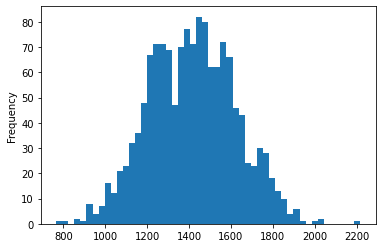

In [5]:
df['price'].plot(kind='hist', bins=50)

In [6]:
model = xgb.XGBRegressor(booster= 'gbtree', base_score=0.5, max_depth=3, early_stopping_rounds=50)

model = model.fit(X_train, y_train,
          eval_set=[(X_train, y_train)],
          verbose = False)
pr = model.predict (X_test)
pr_full = model.predict (X_full_test)
rmse_res = mse(y_test, pr, squared=False)
mape_res = mape(y_test, pr)
print("RMSE:", round(rmse_res, 2), "MAPE:", round(mape_res, 3))

RMSE: 129.81 MAPE: 0.067


Text(0, 0.5, 'price')

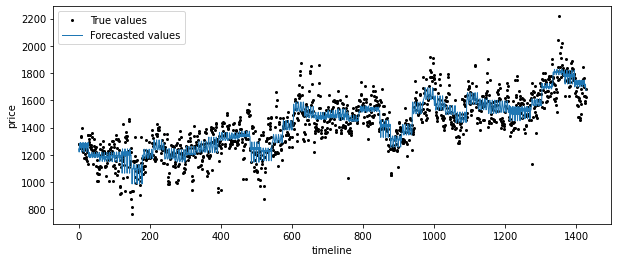

In [7]:
plt.figure(figsize=(10,4))
plt.plot(df['price'], 'o', label = "True values", color='black', markersize=2)
plt.plot(pr_full, label = "Forecasted values", linewidth = 1)
plt.legend()
plt.xlabel('timeline')
plt.ylabel('price')

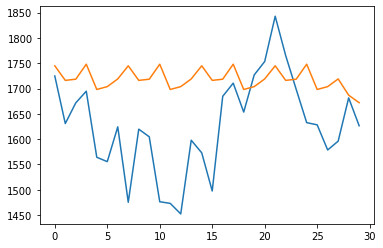

In [8]:
plt.plot(y_test.tolist())
plt.plot(pr)

### XGBoost with forecasted neighbour prices

In [9]:
# predicting the neighbour prices
neighbor_predictions = {}
df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
max_forecast_days = 30
nodes = df.columns.to_list()[5:]
train, test = df[:-max_forecast_days], df[-max_forecast_days:]
features = ['day_of_week', 'month', 'year'] 

X_train = train [features]
X_test = test [features]

# forecastig using forecasted neighbor prices

model = xgb.XGBRegressor(booster= 'gbtree', base_score=0.5, max_depth=3)   
for node in nodes:
    print ("working for:",node)
    y_train = train [node]
    y_test = test [node]
    model = model.fit(X_train, y_train,
              eval_set=[(X_train, y_train)],
              verbose = False)
    pr = model.predict (X_test)
    rmse_res = mse(y_test, pr, squared=False)
    mape_res = mape(y_test, pr)
    neighbor_predictions[node] = pr
    print("RMSE:", round(rmse_res, 2), "MAPE:", round(mape_res, 3))


working for: 100414
RMSE: 144.27 MAPE: 0.078
working for: 100415
RMSE: 131.75 MAPE: 0.069
working for: 100416
RMSE: 133.58 MAPE: 0.07
working for: 100442
RMSE: 136.49 MAPE: 0.07
working for: 100448
RMSE: 132.89 MAPE: 0.068
working for: 100458
RMSE: 131.0 MAPE: 0.067
working for: 100462
RMSE: 136.91 MAPE: 0.072
working for: 100467
RMSE: 134.08 MAPE: 0.069
working for: 100476
RMSE: 134.09 MAPE: 0.068
working for: 101448
RMSE: 131.7 MAPE: 0.067


In [10]:
exogs = pd.DataFrame.from_dict(neighbor_predictions)

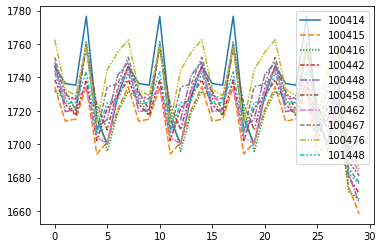

In [11]:
g = sns.lineplot(data=exogs)

In [12]:
X_train = train [features + nodes] # adding nodes names as we need the neighbours nodes prices to be evaluated as exogs
y_train = train ['price']
X_test = test[features]
X_test = X_test.reset_index(drop = True)
X_test[nodes] = exogs[nodes] # as we use the "clean" input, we are not adding nodes prices as they are unknown (forecasted)
y_test = test ['price']

In [13]:
model = xgb.XGBRegressor(booster= 'gbtree', base_score=0.5, max_depth=3, early_stopping_rounds=50)
model = model.fit(X_train, y_train,
          eval_set=[(X_train, y_train)],
          verbose = False)
pr = model.predict (X_test)
rmse_res = mse(y_test, pr, squared=False)
mape_res = mape(y_test, pr)
print("RMSE:", round(rmse_res, 2), "MAPE:", round(mape_res, 3))

RMSE: 128.58 MAPE: 0.066


### XGBoost with lagged neighbour prices

In [15]:
"""
Returns predicted values, RMSE and MAPE of XGBoost model 
based on a required neihbour lag input  
"""
def forecast_xgboost_with_lagged_input (data, first_column_of_neighbor, lag, eval_mode = 1):
    data = data.copy()
    nodes = data.columns.to_list()[first_column_of_neighbor:]
    for node in nodes:
        data[node] = data[node].shift(lag)
    data.dropna(inplace=True)
    
    train, test = data[:-max_forecast_days], data[-max_forecast_days:]
    features = ['day_of_week', 'month', 'year'] + nodes
    target = 'price'
    X_train = train [features]
    y_train = train [target]
    X_test = test [features]
    y_test = test [target]

    if (eval_mode == 1):
        eval_set = [(X_train, y_train)]
    elif (eval_mode == 2):
        eval_set = [(X_train, y_train), (X_test, y_test)]
    model = xgb.XGBRegressor(booster= 'gbtree', base_score=0.5, max_depth=3, 
                          #   n_estimators = 1000,
                             #learning_rate = 0.01, 
                            early_stopping_rounds=50
                            )
    model = model.fit(X_train, y_train, eval_set=eval_set, verbose = False)
    pr = model.predict (X_test)
    rmse_res = mse(y_test, pr, squared=False)
    mape_res = mape(y_test, pr)
    print("Lag:",lag, "RMSE:", round(rmse_res,2), "MAPE:", round(mape_res, 3))
    return {'values': pr, 'rmse':rmse_res, 'mape':mape_res}

In [16]:
frcs = forecast_xgboost_with_lagged_input(df, 5, 366)

Lag: 366 RMSE: 114.03 MAPE: 0.061


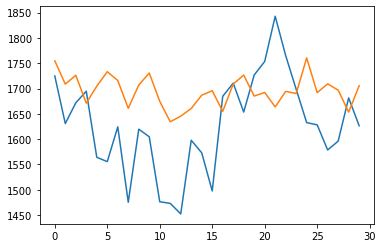

In [17]:
plt.plot(y_test.tolist())
plt.plot(frcs['values'])

### Looking for the best lag

In [18]:
# looking for the best forecasting lag
p = {'lag':[],'rmse':[], 'mape':[]}
for i in range(31, 368):
    df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
    # df.set_index('date', inplace = True)
    frcs = forecast_xgboost_with_lagged_input(df, 5, i)
    p['lag'].append(i)
    p['rmse'].append(frcs['rmse'])
    p['mape'].append(frcs['mape'])

Lag: 31 RMSE: 118.95 MAPE: 0.063
Lag: 32 RMSE: 120.19 MAPE: 0.062
Lag: 33 RMSE: 131.41 MAPE: 0.065
Lag: 34 RMSE: 123.28 MAPE: 0.061
Lag: 35 RMSE: 144.78 MAPE: 0.074
Lag: 36 RMSE: 126.3 MAPE: 0.065
Lag: 37 RMSE: 144.73 MAPE: 0.079
Lag: 38 RMSE: 144.15 MAPE: 0.079
Lag: 39 RMSE: 140.37 MAPE: 0.073
Lag: 40 RMSE: 154.94 MAPE: 0.082
Lag: 41 RMSE: 132.23 MAPE: 0.065
Lag: 42 RMSE: 149.15 MAPE: 0.08
Lag: 43 RMSE: 129.22 MAPE: 0.068
Lag: 44 RMSE: 136.14 MAPE: 0.068
Lag: 45 RMSE: 143.87 MAPE: 0.077
Lag: 46 RMSE: 134.38 MAPE: 0.07
Lag: 47 RMSE: 136.82 MAPE: 0.069
Lag: 48 RMSE: 145.74 MAPE: 0.073
Lag: 49 RMSE: 129.96 MAPE: 0.068
Lag: 50 RMSE: 156.33 MAPE: 0.079
Lag: 51 RMSE: 153.85 MAPE: 0.087
Lag: 52 RMSE: 182.55 MAPE: 0.098
Lag: 53 RMSE: 173.26 MAPE: 0.096
Lag: 54 RMSE: 158.73 MAPE: 0.083
Lag: 55 RMSE: 122.11 MAPE: 0.062
Lag: 56 RMSE: 123.71 MAPE: 0.064
Lag: 57 RMSE: 120.13 MAPE: 0.061
Lag: 58 RMSE: 134.8 MAPE: 0.069
Lag: 59 RMSE: 154.05 MAPE: 0.082
Lag: 60 RMSE: 150.45 MAPE: 0.078
Lag: 61 RMSE: 

Lag: 276 RMSE: 144.76 MAPE: 0.077
Lag: 277 RMSE: 135.5 MAPE: 0.074
Lag: 278 RMSE: 138.6 MAPE: 0.073
Lag: 279 RMSE: 135.5 MAPE: 0.07
Lag: 280 RMSE: 129.75 MAPE: 0.064
Lag: 281 RMSE: 114.37 MAPE: 0.06
Lag: 282 RMSE: 133.6 MAPE: 0.069
Lag: 283 RMSE: 131.19 MAPE: 0.068
Lag: 284 RMSE: 129.22 MAPE: 0.066
Lag: 285 RMSE: 126.98 MAPE: 0.064
Lag: 286 RMSE: 124.7 MAPE: 0.065
Lag: 287 RMSE: 146.97 MAPE: 0.079
Lag: 288 RMSE: 151.93 MAPE: 0.082
Lag: 289 RMSE: 151.81 MAPE: 0.08
Lag: 290 RMSE: 126.21 MAPE: 0.066
Lag: 291 RMSE: 145.79 MAPE: 0.078
Lag: 292 RMSE: 154.59 MAPE: 0.081
Lag: 293 RMSE: 170.47 MAPE: 0.088
Lag: 294 RMSE: 147.31 MAPE: 0.074
Lag: 295 RMSE: 122.4 MAPE: 0.059
Lag: 296 RMSE: 124.51 MAPE: 0.063
Lag: 297 RMSE: 119.3 MAPE: 0.062
Lag: 298 RMSE: 134.8 MAPE: 0.068
Lag: 299 RMSE: 109.03 MAPE: 0.057
Lag: 300 RMSE: 125.24 MAPE: 0.061
Lag: 301 RMSE: 120.25 MAPE: 0.061
Lag: 302 RMSE: 126.17 MAPE: 0.065
Lag: 303 RMSE: 125.47 MAPE: 0.061
Lag: 304 RMSE: 119.74 MAPE: 0.058
Lag: 305 RMSE: 136.08 MAP

In [19]:
t = pd.DataFrame.from_dict(p)
t['weeks'] = t['lag']/7

In [20]:
t.loc[(t['rmse']<115)]

,lag,rmse,mape,weeks
76,107,113.527272,0.058567,15.285714
97,128,109.411685,0.055508,18.285714
184,215,114.918161,0.062135,30.714286
208,239,111.701449,0.056795,34.142857
250,281,114.369675,0.059702,40.142857
268,299,109.029555,0.056781,42.714286
303,334,113.679968,0.057406,47.714286
335,366,114.033029,0.061429,52.285714


### Dishonest experiment

In [23]:
frcs = forecast_xgboost_with_lagged_input(df, 5, 366, eval_mode=2)

Lag: 366 RMSE: 97.07 MAPE: 0.049


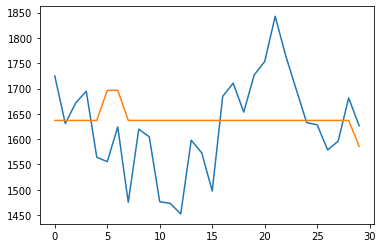

In [25]:
plt.plot(y_test.tolist())
plt.plot(frcs['values'])

In [28]:
df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])

In [29]:
max_forecast_days = 30
train, test = df[:-max_forecast_days], df[-max_forecast_days:]
features = ['day_of_week', 'month', 'year']
target = 'price'
X_train = train [features]
y_train = train [target]
X_test = test [features]
y_test = test [target]

In [30]:
X_full_test = df[features]
model = xgb.XGBRegressor(booster= 'gbtree', base_score=0.5, max_depth=3, early_stopping_rounds=50)

model = model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose = False)
pr = model.predict (X_test)
pr_full = model.predict (X_full_test)
rmse_res = mse(y_test, pr, squared=False)
mape_res = mape(y_test, pr)
print("RMSE:", round(rmse_res, 2), "MAPE:", round(mape_res, 3))

RMSE: 93.28 MAPE: 0.045


Text(0, 0.5, 'price')

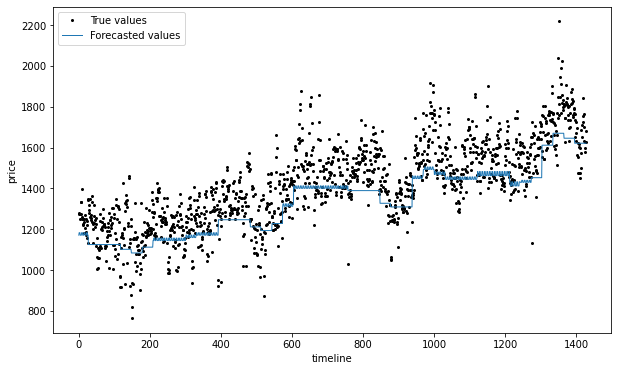

In [32]:
plt.figure(figsize=(10,6))
plt.plot(df['price'], 'o', label = "True values", color='black', markersize=2)
plt.plot(pr_full, label = "Forecasted values", linewidth = 1)
plt.legend()
plt.xlabel('timeline')
plt.ylabel('price')